<IPython.core.display.Javascript object>


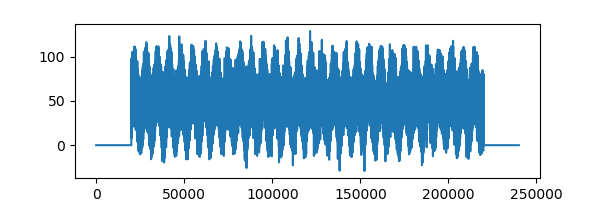

In [8]:
from labdaq import *

%matplotlib notebook
import pylab as plt
plt.figure(figsize=(6,2))
plt.plot(stimgen_waveform([[1,1,0,10,1,0,0,0,0,0],
                           [10,2,0,10,0,0,0,0,0,0],
                           [1,3,20,3,0,0,0,0,0,1],
                           [1,1,50,0,0,0,0,0,1,1],
                          [1,1,0,0,1,0,0,0,0,0]]));


In [84]:
%gui qt5
import os
from PyQt5.QtWidgets import (QApplication,
                             QWidget,
                             QMainWindow,
                             QDockWidget,
                             QFormLayout,
                             QHBoxLayout,
                             QGridLayout,
                             QVBoxLayout,
                             QPushButton,
                             QGridLayout,
                             QTreeWidgetItem,
                             QTreeView,
                             QTextEdit,
                             QLineEdit,
                             QCheckBox,
                             QComboBox,
                             QListWidget,
                             QLabel,
                             QProgressBar,
                             QFileDialog,
                             QMessageBox,
                             QDesktopWidget,
                             QListWidgetItem,
                             QFileSystemModel,
                             QAbstractItemView,
                             QMenu, QAction)

from PyQt5 import QtCore
from PyQt5.QtGui import QStandardItem, QStandardItemModel,QColor
from PyQt5.QtCore import Qt, QTimer,QMimeData
import pyqtgraph as pg

class ProtocolFileViewer(QTreeView):
     def __init__(self,folder,parent=None):
        super(ProtocolFileViewer,self).__init__()
        self.parent = parent
        self.fs_model = QFileSystemModel(self)
        self.fs_model.setReadOnly(True)
        self.setModel(self.fs_model)
        self.folder = folder
        self.setRootIndex(self.fs_model.setRootPath(folder))
        #self.fs_model.removeColumn(1)
        self.setAlternatingRowColors(True)
        self.setSelectionMode(3)
#         self.setDragEnabled(True)
#         self.setAcceptDrops(True)
#         self.setDragDropMode(QAbstractItemView.DragDrop)
#         self.setDropIndicatorShown(True)
#         #[self.hideColumn(i) for i in range(1,4)]
        self.setColumnWidth(0,self.width()*.3)
        def query_root(self):
            folder = QFileDialog().getExistingDirectory(self,"Select directory",os.path.curdir)
            self.setRootIndex(self.fs_model.setRootPath(folder))
            self.expandAll()
            self.folder = folder
            if hasattr(self.parent,'folder'):
                self.parent.folder.setText('{0}'.format(folder))
# A widget to display and generate protocol files
class StimgenWidget(QWidget):
    def __init__(self,protocolsfolder = None):
        super(StimgenWidget,self).__init__()
        #mainw = QWidget()
        #self.setWidget(mainw)
        lay = QGridLayout()
        self.setLayout(lay)
        self.fbrowse = ProtocolFileViewer(os.path.expanduser('~')+'/lib/labdaq')
        self.stimgenfile = QTextEdit()
        self.plotw = pg.PlotWidget()
        self.plots = []
        lay.addWidget(self.fbrowse,0,0,2,1)
        lay.addWidget(self.stimgenfile,2,0,1,2)
        lay.addWidget(self.plotw,0,1,1,2)
        self.srate = 20000
        prot = [[.5,1,0,10,1,0,0,0,0,0],
                [0.1,1,-500,0,0,0,0,0,0,0],
                [1,1,1,0,0,0,0,0,0,0],
                [1,1,-200,0,0,0,0,0,0,0],
                [1.5,1,0,10,0,0,0,0,0,0],
                [20,2,0,20,0,0,0,0,0,0],
                [1,1,0,0,1,0,0,0,0,0]]
        txt = '\n'.join(['\t'.join([str(a) for a in x]) for x in prot]) 
        x = stimgen_waveform([[.5,1,0,10,1,0,0,0,0,0],
                              [0.1,1,-500,0,0,0,0,0,0,0],
                              [1,1,1,0,0,0,0,0,0,0],
                              [1,1,-200,0,0,0,0,0,0,0],
                              [1.5,1,0,10,0,0,0,0,0,0],
                              [20,2,0,20,0,0,0,0,0,0],
                              [1,1,0,0,1,0,0,0,0,0]])
        self.plots.append(self.plotw.plot(np.arange(len(x))/self.srate,x))
        self.stimgenfile.setText(txt)
test = StimgenWidget()
test.show()